# 0. Description
This notebook is part of Pose Classification Application for children ADHD Detecting.

Following contents will include
    - Training code with Pytorch
    - Training loss and validation loss matplot
    - Early stopping to prevent overfitting
    - visualizing else

In [33]:
a = np.linspace(0, np.pi, seq_length*input_size)
a[1]

6.518232781272265e-05

# 1. Setting

In [1]:
!pip install torch torchvision tqdm matplotlib mediapipe pandas

In [2]:
# Libraries
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import math
from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('USING pyTorch Version:', torch.__version__, ' Device:', DEVICE)

mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

/home/ubuntu/Action_Recognition/Baby-Action-Recognition/mp_env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


USING pyTorch Version: 1.10.1+cu102  Device: cpu


In [3]:
# Mediapipe function setting

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results


def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections
    
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 
    
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

## 얘는 한 프레임에 pose, face, lh, rh 가 한 행에 다 flatten 되어있는 형태로 만들어짐.

# 2. Data Loading and Preprocessing

In [5]:
# Setup for X, y

# Actions that we try to detect
actions = np.array(['sitting', 'standing','walking','running','kicking','punching'])

# Data path
DATA_PATH = os.path.join('../video_training') 

# y setting
label_map = {label:num for num, label in enumerate(actions)}

# X and y setting
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(1, 30):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
        
X = np.array(sequences)
y = to_categorical(labels).astype(int)

# ??? 왜 해야하는지 모르겠다. 연산에서 사이즈 안맞아서 이렇게 했다.
#X = X.swapaxes(1,2)
print("X shape is: {} \ny shape is: {}".format(X.shape, y.shape))

X shape is: (180, 29, 1662) 
y shape is: (180, 6)


In [225]:
# train test split

## x is (180, 1662, 29), 180 = 30 folders for 6 actions.
## last 3 folders will become test data.

train_dataset_x = X[0:27]
train_dataset_y = y[0:27]

test_dataset_x = X[27:30]
test_dataset_y = y[27:30]

for i in range(2,7):
    train_dataset_x = np.concatenate((train_dataset_x, X[(i-1)*30:i*30-3]), axis = 0)
    train_dataset_y = np.concatenate((train_dataset_y, y[(i-1)*30:i*30-3]), axis = 0)
   
    test_dataset_x = np.concatenate((test_dataset_x, X[i*30-3:i*30]), axis = 0)
    test_dataset_y = np.concatenate((test_dataset_y, y[i*30-3:i*30]), axis = 0)

print("train X shape: {} \ttest X shape: {}".format(train_dataset_x.shape, test_dataset_x.shape))
print("train y shape: {} \ttest y shape: {}".format(train_dataset_y.shape, test_dataset_y.shape))

train X shape: (162, 29, 1662) 	test X shape: (18, 29, 1662)
train y shape: (162, 6) 	test y shape: (18, 6)


In [90]:
train_dataset_y[0]

array([1, 0, 0, 0, 0, 0])

In [34]:
?nn.RNN

In [108]:
## RNN output size test

input_size = 1662  # 입력 데이터 특성 차원
hidden_dim = 64 # hidden state 차원
n_layers = 2    # stacking layer 개수

rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=False)

# 20개의 시퀀스 생성
seq_length = 29

time_steps = np.linspace(0, np.pi, seq_length*input_size) # 0~pi까지 3번째 인자 수만큼 생성
print(time_steps.shape)
# (48198,)

data = np.sin(time_steps)
data.resize((seq_length, input_size))
print(data.shape)
# (29, 1662)

# 배치 차원 추가(0번째)
input_data = torch.Tensor(data).unsqueeze(0)
print('Input size: ', input_data.size())
# torch.Size([1, 29, 1662])

output, hidden_state = rnn(input_data, None)

# output shape: [batch_size, sequence_length, hidden_dim]
print('Output: ', output.size()) # Output:  torch.Size([1, 29, 64])

# hidden shape: [num_layers, batch_size, hidden_dim]
print('Hidden State: ', hidden_state.size()) # Hidden State:  torch.Size([2, 1, 64])


_fc = nn.Sequential(nn.Linear(hidden_size, 32), nn.Linear(32, 6), 
                                nn.Sigmoid(), nn.Softmax(dim=1))
# soft max dim =2 를 하면 행 원소들의 합이 1이 된다. dim=1이면 열 원소의 합이 1이다.(2차원일 때)
# 1차원이면 dim =1 이 행 원소의 합을 의미


_out_trial = _fc(output)
_out_trial_cut = torch.tensor(_fc(output[:, -1, :]), dtype=torch.float32)
print('After Linear, size: \n', _out_trial) # torch.Size([1, 29, 6])
print('After Linear, cut size: \n', _out_trial_cut) #  torch.Size([1, 6])

# 나는 이것들의 평균을 내야하나, 아니면 1,6 으로 만드는 방법이 뭐가 있나, 모델이 틀렸나 고민계속했는데,,,
# 각 동작에서의 확률인줄 알았는데 ...
# (1662, 29) 였을 때도 그럼 그냥 마지막 거 해도 되는 거였음 ;;

# 음, 근데 왜 내 BASEMODEL에서는 동작을 안하냐?

# befor fc, out shape:  torch.Size([27, 29, 64])
# inside of model, out shape:  torch.Size([27, 6]) 로 나오네... 27은 batch size인데..

(48198,)
(29, 1662)
Input size:  torch.Size([1, 29, 1662])
Output:  torch.Size([1, 29, 64])
Hidden State:  torch.Size([2, 29, 64])
After Linear, size: 
 tensor([[[0.0344, 0.0331, 0.0350, 0.0352, 0.0342, 0.0327],
         [0.0345, 0.0340, 0.0346, 0.0349, 0.0345, 0.0337],
         [0.0345, 0.0344, 0.0344, 0.0347, 0.0345, 0.0343],
         [0.0346, 0.0345, 0.0344, 0.0346, 0.0345, 0.0346],
         [0.0346, 0.0346, 0.0344, 0.0346, 0.0345, 0.0347],
         [0.0346, 0.0346, 0.0344, 0.0345, 0.0345, 0.0348],
         [0.0346, 0.0346, 0.0344, 0.0345, 0.0345, 0.0348],
         [0.0345, 0.0346, 0.0344, 0.0345, 0.0345, 0.0347],
         [0.0345, 0.0346, 0.0345, 0.0345, 0.0345, 0.0347],
         [0.0345, 0.0346, 0.0345, 0.0344, 0.0345, 0.0347],
         [0.0345, 0.0346, 0.0345, 0.0344, 0.0345, 0.0347],
         [0.0345, 0.0346, 0.0345, 0.0344, 0.0345, 0.0347],
         [0.0345, 0.0346, 0.0345, 0.0344, 0.0345, 0.0347],
         [0.0345, 0.0346, 0.0345, 0.0344, 0.0345, 0.0347],
         [0.0345, 0.0

/home/ubuntu/Action_Recognition/Baby-Action-Recognition/mp_env/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [96]:
from torch.autograd import Variable
classes_no = 6
_ex_batch_size = 27
_target = Variable(torch.LongTensor(_ex_batch_size).random_(0, classes_no))
_target

tensor([3, 5, 5, 2, 3, 0, 1, 1, 5, 1, 4, 4, 1, 1, 2, 3, 2, 1, 3, 0, 1, 2, 2, 5,
        5, 3, 5])

In [ ]:
"""
구글링 :
In the batch first mode (which is what you have), the output has this meaning:
batch * seq_len * vector size
So with a -1 in the middle dimension, you are extracting the very last output of time series output sequence of the RNN. This final output represents the summary of the entire sequence and that is what you want for a many to one scenario. The other :'s just means you want that last output for all batch and all input vectors.

-> batch_first 모드에서는 rnn 아웃풋이 input seq_len을 따르게 하기 때문에, 
    out = self.fc(out[:, -1, :])
와 같은 형태로 마지막 값만을 사용하는 것으로(== last time stamp) classification을 수행한다고 한다.

그리고 아마,, batch_first=true 를 쓰지 않으면
    # output shape: (seq_len, batch, hidden_size * num_directions):
    x = output[-1] # this is batch * hidden_size for unidirectional LSTM / RNN
과 같이 -1 만 하면 되는 듯.

"""

In [226]:

from torch.utils.data import DataLoader
#input_size = 29
input_size = 1662
batch_size = 27
num_layers = 1
hidden_size = 64
output_size = actions.shape[0]

# 아래를 왜 하는지 알아보자 추후에.
train_dataset_x = torch.tensor(train_dataset_x, dtype=torch.float32)
train_dataset_y = torch.tensor(train_dataset_y, dtype=torch.float32)

test_dataset_x = torch.tensor(test_dataset_x, dtype=torch.float32)
test_dataset_y = torch.tensor(test_dataset_y, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(train_dataset_x, train_dataset_y)
test_dataset = torch.utils.data.TensorDataset(test_dataset_x, test_dataset_y)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


"""
    output, hidden_state = rnn(input, none)
        # output shape: [batch_size, sequence_length, hidden_dim]
        # Output:  torch.Size([1, 29, 64]) 이런 결과가 나온다. 흠. 맞는데.
        
            
        # hidden shape: [num_layers, batch_size, hidden_dim]
        print('Hidden State: ', hidden_state.size())
        # Hidden State:  torch.Size([2, 1, 64])
        
        
        # linear 까지 통과된 것의 모양을 (1, 1, 6)으로 하고싶은 것.

"""

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.device = DEVICE
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size, output_size), 
                                nn.Sigmoid(), nn.Softmax(dim=1))
        # LSTM = input_size, hidden_size, num_layers, bias, batch_first, dropout, bidirectional
        #self.LSTM_1 = nn.LSTM(29, 64, 1)
        #self.fc = nn.Linear(64, actions.shape[0])
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size)# 초기 hidden state 설정하기.
            # h0.shape # torch.Size([num_layer, batch_size, hidden_size])
            # == (1, 27, 64)
        out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. hn: hidden state를 반환한다.
        #print("out's shape: {}".format(out.shape))
        #out = out.reshape(out.shape[0], -1) # many to many 전략
        
        
        #print("befor fc, out shape: ", out.shape) # out shape:  torch.Size([27, 29, 64])
        out = self.fc(out[:, -1, :])
        #print("inside of model, out shape: ", out.shape) # out shape:  torch.Size([27, 6])
        
        return out

model = BaseModel()

# 3. DL model setting and training

In [227]:
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
min_loss = np.Inf

num_epochs = 300

train_loss_graph = [] # 그래프 그릴 목적인 loss.
valid_loss_graph = []

exlr_point_x = [] # exponential LR 을 그릴 목적
exlr_point_y = []
n = len(train_dataloader)


for epoch in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    n_batches = 0
    
    model.train()
    for data in tqdm(train_dataloader):
        #print("epoch: {}".format(epoch))
        seq, target = data # 배치 데이터.
        #print("seq type: {} \tseq shape:")
        #print('seq shape: {} \ttarget shape: {}'.format(seq.shape, target.shape))
            # seq shape: torch.Size([10, 29, 1662]) 
            # target shape: torch.Size([10, 6])
        
        optimizer.zero_grad() # 
        out = model(seq)   # 모델에 넣고,
        
            #print("seq shape: {}\t out shape: {}".format(seq.shape, out.shape))
            #print("out value: \n", out)
            # seq shape: torch.Size([27, 29, 1662])	 out shape: torch.Size([27, 6])
            # 현재 배치 단위로 학습하기 때문에, 1차원이 배치로 나오고 있음에 헷갈리지 말자.

            #print("target shape: {}".format(type(target)))
            # target shape: torch.Size([27, 6])
            #print("target value: ", target)
            # tensor([[0., 0., 0., 1., 0., 0.], ....
        
        loss = criterion(out, target) # output 가지고 loss 구하고,        
        loss.backward() # loss가 최소가 되게하는
        
        optimizer.step() # 가중치 업데이트 해주고,
        train_loss += loss.item() # 한 배치의 loss 더해주고,
        
        n_batches +=1
        
    train_loss /= n_batches
    train_loss_graph.append(train_loss)
    
    ## validation loss
    model.eval()
    t_batches = 0
    for test_data in tqdm(test_dataloader):
        test_seq, test_target = test_data
        
        test_out = model(test_seq)
        
        test_loss = criterion(test_out, test_target)
        
        valid_loss += test_loss.item()
        
        t_batches += 1
    
    valid_loss /= t_batches
    valid_loss_graph.append(valid_loss)
    
    if(epoch % 10 == 0):
        print('[epoch: {}] train loss: {:.4f}\t valid loss: {:.4f}'.format(epoch, train_loss, valid_loss))
    if(epoch % 30 == 0):
        scheduler.step()
        exlr_point_x.append(epoch)

exlr_point_y.append(min(train_loss_graph))
exlr_point_y.append(max(train_loss_graph))

100%|██████████| 1/1 [00:00<00:00, 205.45it/s]


[epoch: 0] train loss: 1.7993	 valid loss: 1.7910


100%|██████████| 1/1 [00:00<00:00, 179.83it/s]


[epoch: 10] train loss: 1.7877	 valid loss: 1.7892


100%|██████████| 1/1 [00:00<00:00, 197.63it/s]


[epoch: 20] train loss: 1.7820	 valid loss: 1.7849


100%|██████████| 1/1 [00:00<00:00, 236.91it/s]


[epoch: 30] train loss: 1.7665	 valid loss: 1.7677


100%|██████████| 1/1 [00:00<00:00, 210.92it/s]


[epoch: 40] train loss: 1.7594	 valid loss: 1.7620


100%|██████████| 1/1 [00:00<00:00, 221.65it/s]


[epoch: 50] train loss: 1.7545	 valid loss: 1.7568


100%|██████████| 1/1 [00:00<00:00, 261.88it/s]


[epoch: 60] train loss: 1.7499	 valid loss: 1.7509


100%|██████████| 1/1 [00:00<00:00, 214.26it/s]


[epoch: 70] train loss: 1.7467	 valid loss: 1.7474


100%|██████████| 1/1 [00:00<00:00, 233.61it/s]


[epoch: 80] train loss: 1.7430	 valid loss: 1.7433


100%|██████████| 1/1 [00:00<00:00, 197.06it/s]


[epoch: 90] train loss: 1.7386	 valid loss: 1.7389


100%|██████████| 1/1 [00:00<00:00, 201.28it/s]


[epoch: 100] train loss: 1.7361	 valid loss: 1.7374


100%|██████████| 1/1 [00:00<00:00, 228.51it/s]


[epoch: 110] train loss: 1.7341	 valid loss: 1.7360


100%|██████████| 1/1 [00:00<00:00, 205.44it/s]


[epoch: 120] train loss: 1.7324	 valid loss: 1.7349


100%|██████████| 1/1 [00:00<00:00, 95.57it/s]


[epoch: 130] train loss: 1.7306	 valid loss: 1.7353


100%|██████████| 1/1 [00:00<00:00, 119.38it/s]


[epoch: 140] train loss: 1.7296	 valid loss: 1.7345


100%|██████████| 1/1 [00:00<00:00, 222.16it/s]


[epoch: 150] train loss: 1.7286	 valid loss: 1.7340


100%|██████████| 1/1 [00:00<00:00, 210.27it/s]


[epoch: 160] train loss: 1.7281	 valid loss: 1.7339


100%|██████████| 1/1 [00:00<00:00, 198.90it/s]


[epoch: 170] train loss: 1.7277	 valid loss: 1.7336


100%|██████████| 1/1 [00:00<00:00, 192.21it/s]


[epoch: 180] train loss: 1.7273	 valid loss: 1.7334


100%|██████████| 1/1 [00:00<00:00, 200.24it/s]


[epoch: 190] train loss: 1.7271	 valid loss: 1.7333


100%|██████████| 1/1 [00:00<00:00, 201.56it/s]


[epoch: 200] train loss: 1.7269	 valid loss: 1.7332


100%|██████████| 1/1 [00:00<00:00, 206.07it/s]


[epoch: 210] train loss: 1.7267	 valid loss: 1.7331


100%|██████████| 1/1 [00:00<00:00, 210.35it/s]


[epoch: 220] train loss: 1.7267	 valid loss: 1.7330


100%|██████████| 1/1 [00:00<00:00, 211.01it/s]


[epoch: 230] train loss: 1.7266	 valid loss: 1.7330


100%|██████████| 1/1 [00:00<00:00, 213.62it/s]


[epoch: 240] train loss: 1.7265	 valid loss: 1.7330


100%|██████████| 1/1 [00:00<00:00, 184.19it/s]


[epoch: 250] train loss: 1.7264	 valid loss: 1.7330


100%|██████████| 1/1 [00:00<00:00, 221.84it/s]


[epoch: 260] train loss: 1.7264	 valid loss: 1.7329


100%|██████████| 1/1 [00:00<00:00, 178.94it/s]


[epoch: 270] train loss: 1.7264	 valid loss: 1.7329


100%|██████████| 1/1 [00:00<00:00, 172.88it/s]


[epoch: 280] train loss: 1.7263	 valid loss: 1.7329


100%|██████████| 1/1 [00:00<00:00, 232.85it/s]


[epoch: 290] train loss: 1.7263	 valid loss: 1.7329


100%|██████████| 1/1 [00:00<00:00, 226.69it/s]


In [171]:
model

BaseModel(
  (rnn): RNN(1662, 64, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=6, bias=True)
    (1): Sigmoid()
    (2): Softmax(dim=1)
  )
)

In [ ]:
exlr_point

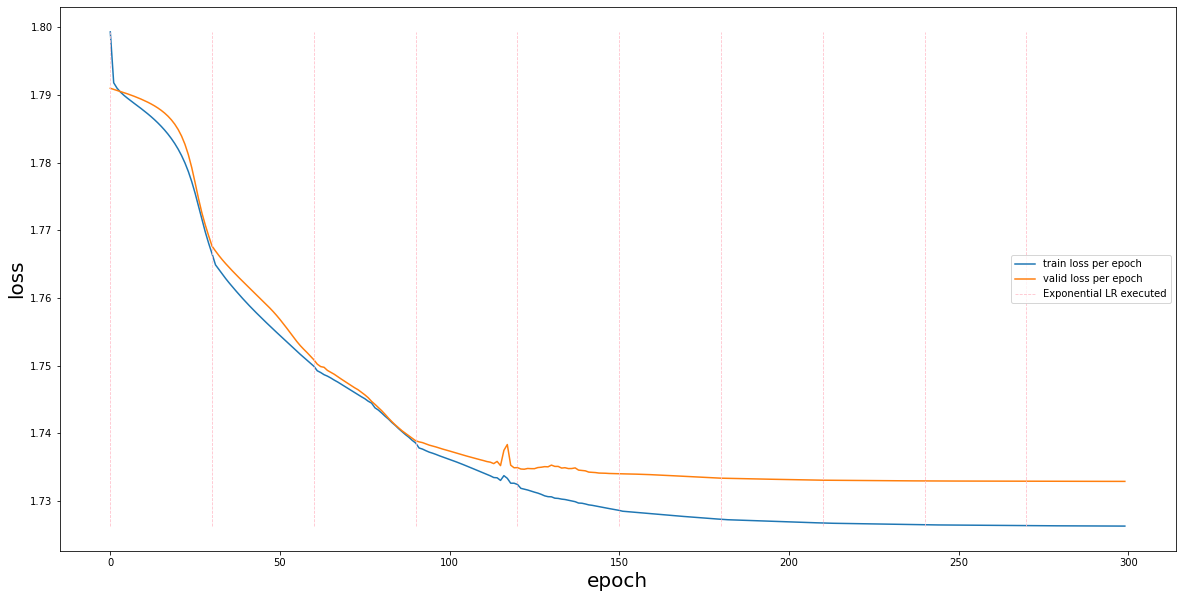

In [229]:
plt.figure(figsize=(20,10))
#_x_value = num_epochs

plt.plot(train_loss_graph, label='train loss per epoch')
plt.plot(valid_loss_graph, label='valid loss per epoch')
plt.plot([exlr_point_x[0], exlr_point_x[0]], exlr_point_y, label='Exponential LR executed', linestyle='--', c='pink', linewidth=0.8)

for i in range(1, len(exlr_point_x)):
    plt.plot([exlr_point_x[i], exlr_point_x[i]], exlr_point_y, linestyle='--', c='pink', linewidth=0.8)

plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.legend()
plt.savefig('../images/RNN-1662-64_FC-6_valid_ExLR2.png',dpi=300)
plt.show()

# 4. Model save and Test

In [230]:
# model save
from time import time, gmtime, localtime

_time = time()
_time = gmtime(_time)

# _h5_file_name = '../model/RNN_ver' + str(_time.tm_mon) + str(_time.tm_mday) + '_2_softmax.pt'
_h5_file_name = '../model/1019RNN-1662-64_FC-6_valid_ExLR.pt'

torch.save(model.state_dict(), _h5_file_name)

In [231]:
# model load

model = BaseModel()
#model.load_state_dict(torch.load('../model/RNN_ver1019_2_softmax.pt'))
model.load_state_dict(torch.load('../model/1019RNN-1662-64_FC-6_valid_ExLR.pt'))

<All keys matched successfully>

In [125]:
# predict function

## set the Test function

def predict_oneframe(image): # for just one frame prediction
    '''
    criterion = nn.CrossEntropyLoss()
    model = model.to(DEVICE)
    '''
    #model.eval()

    correct = 0
    predict = 0
    cost = 0
    n_batches = 0
    loss_evaluate = 0
    
    model.eval()
    
    with torch.no_grad():
        #image = image.to(DEVICE)
        
        y_hat = model(image)
        y_hat.argmax()
        
    return y_hat

In [11]:
'''_max_count = np.zeros(6)

for i in range(0, 1662):
    _max_idx = np.argmax(res[i])
    #print("max idx : ", type(_max_idx))
    _max_count[_max_idx] += 1

    
print("result: ", _max_count)
'''

'_max_count = np.zeros(6)\n\nfor i in range(0, 1662):\n    _max_idx = np.argmax(res[i])\n    #print("max idx : ", type(_max_idx))\n    _max_count[_max_idx] += 1\n\n    \nprint("result: ", _max_count)\n'

In [165]:
colors = [(245,117,16), (117,245,16), (16,117,245), (245,117,16), (117,245,16), (16,117,245)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        # rectangle(img, (start_x, start_y), (end_x, end_y), color, line_width, line종류, fractional bit)
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [234]:
# this is for test - predict_oneframe()
import pandas as pd
from time import time, gmtime, localtime

def _get_time():
    _ct = gmtime(time())
    hour = _ct.tm_hour+9
    minute = _ct.tm_min
    
    return _ct, hour, minute

def action_record(bh, bm, ct, action, c):
    _t = ct
    
    _year = _t.tm_year
    _month = _t.tm_mon
    _day = _t.tm_mday
    _hour = _t.tm_hour+9
    _min = _t.tm_min
    _action = actions[action]
    _du_h = _hour - bh
    _du_m = _min - bm
    
    _du = _du_h*60 + _du_m
    _co = action_count[action]
    
    action_time_log.loc[c-1] = [_year, _month, _day, _hour, _min, _action, 0, _co]
    
    if c != 1:
        action_time_log.loc[c-2,'Duration'] = _du
    return _hour, _min

# action count, time logging
action_count = np.zeros(actions.shape[0])
action_time_log = pd.DataFrame(columns=['Year', 'Month', 'Day', 'Hour', 'Minute','Action','Duration','Count'])


sequence = []
sentence = []
predictions = []
threshold = 0.5
co = 0
_new_h = 0
_new_m = 0
_bef_h = 0
_bef_m = 0

cap = cv2.VideoCapture('../input2.avi')
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        #print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-29:]
        
        if len(sequence) == 29:
            #sequence_test = np.expand_dims(sequence, axis=0).swapaxes(1,2)
            sequence_test = np.expand_dims(sequence, axis=0)
            
            
            sequence_test = torch.tensor(sequence_test, dtype=torch.float32)
            #print("30fps, np expand is: ", np.expand_dims(sequence, axis=0))
            #print("shape is: {}".format(np.expand_dims(sequence, axis=0).shape))
                # np.expand_dims(sequence, axis=0) (1, 30, 1662)
                # ex x shape was:                  (180, 30, 1662)
                # train X shape:                   (162, 1662, 29)
                # sequece_test shape:              (1, 1662, 29)
            #print(type(sequence_test))
                # sequence_test type is numpy.ndarray
            res = predict_oneframe(sequence_test)[0]
            rest_try = model(sequence_test)
            #print("seq_test shape: {}\tres_shape: {}, \trest_try_shape: {}".format(sequence_test.shape, res.shape, rest_try.shape))
            
            
            # seq_test shape: torch.Size([1, 29, 1662]) res_shape: torch.Size([29, 6])-> this should be (1, 6) if i want to make it same with org code
            # rest_try_shape: torch.Size([1, 29, 6])
            
            # 애초부터 RNN 모델링이 잘못되었었음!
            # 1. input_dim = 1662이었어야했다(입력 전체 피처 수)
            # 2. 결과가 (1,6) 이려면 ...
            
                    # predict_oneframe shape:          torch.Size([1, 1662, 6])
            
            #print('res: {}'.format(res.shape))
                # res: torch.Size([1662, 6])
            #print('res: {}'.format(predict_oneframe(sequence_test).shape))
                # predict_oneframe(sequence_test) shape: torch.Size([1, 1662, 6])
            
            #print('res shape: {} \targmax: {}'.format(res.shape, np.argmax(res[1])))
                # res shape:                       torch.Size([1662, 6]) 
                # np.argmax(res):                  8
                # 결과 action은 res[1] 에 저장되어있다
                
                
            #print(actions[np.argmax(res[1660])])
            predictions.append(np.argmax(res)) # 이제 res 라는 배열은 (6,)으로 확률을 갖는다.(확률인진 몰라도, 일단 점수임 sigmoid. 모델에서 softmax 추가 시 %로 가능!)
            
            '''
            Action Detection Refined와 shape 비교
            ## 원본 코드
            res = model.predict(np.expand_dims(sequence, axis=0))[0] # shape:(1,6)에서 [0]을 뽑아온 res.shape = (6,)
            predictions.append(np.argmax(res)) # 따라서 (6,)에서의 최댓값으로 인덱싱이 가능
            
            # 여기서의 X.shape = (180, 29, 1662)
            #### -> 180은 배치사이즈로 없어지고, 29는 라벨로 없어지는 듯. (Y_test.shape = (9, 6))
            #### 아 근데 29 라벨로 없어지는 건 내 거도 동일. 
            # 나의    X.shape = (162, 1662, 29) -> 일단 이걸 예제랑 똑같게 고쳤다. (162, 29, 1662) 이제 남은건 (29, 6)으로 출력되는 걸 (1,6)으로 만드는 것.
            
            ## 내 코드
            res = predict_oneframe(sequence_test)[0]
            predictions.append(np.argmax(res[1660]))
            
            고친듯!!
            seq_test shape: torch.Size([1, 29, 1662])	res_shape: torch.Size([6]), 	rest_try_shape: torch.Size([1, 6])

            '''
            
        
        #3. Visualize and count, logging logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): # 최근 10개의 action이 현재 분류된 action과 같으면
            
                if res[np.argmax(res)] > 0.4:                # 그리고 현재 분류된 action의 확률이 threshold를 넘으면
                    
                    if len(sentence) > 0:                          # 처음이 아니면
                        if actions[np.argmax(res)] != sentence[-1]:     # 이전 action과 다를 때만 logging
                            co += 1
                            _a = np.argmax(res)
                            
                            action_count[_a] += 1
                            _action = actions[_a]
                            
                            _bef_h = _new_h
                            _bef_m = _new_m
                            ct, _new_h, _new_m = _get_time()
                            # action_record(bh, bm, ct, action, c)
                            action_record(_bef_h, _bef_m, ct, np.argmax(res), co)
                            print("prob: {}, predicted action: {}". format(res[np.argmax(res)], actions[np.argmax(res)]))
                                  
                            #print(action_record)
                            sentence.append(actions[np.argmax(res)])
                        else:
                            print("prob: {}, predicted as same action".format(res[np.argmax(res)]))
                    else:
                        sentence.append(actions[np.argmax(res)])
                else:
                    print("under threshold, prob is: {}, predicted action is: {}".format(res[np.argmax(res)], actions[np.argmax(res)]))
            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()



under threshold, prob is: 0.27886542677879333, predicted action is: running
under threshold, prob is: 0.232000470161438, predicted action is: running
under threshold, prob is: 0.27548331022262573, predicted action is: running
under threshold, prob is: 0.2844853699207306, predicted action is: running
under threshold, prob is: 0.28218594193458557, predicted action is: running
under threshold, prob is: 0.2820746600627899, predicted action is: running
under threshold, prob is: 0.2817404270172119, predicted action is: running
under threshold, prob is: 0.2823255956172943, predicted action is: running
under threshold, prob is: 0.28219088912010193, predicted action is: running
under threshold, prob is: 0.28234291076660156, predicted action is: running
under threshold, prob is: 0.2822887897491455, predicted action is: running
under threshold, prob is: 0.28230544924736023, predicted action is: running
under threshold, prob is: 0.2824159264564514, predicted action is: running
under threshold, pro

In [235]:
res

tensor([0.1911, 0.1267, 0.1216, 0.2754, 0.1158, 0.1693])

In [142]:
print('res before softmax: ',res) # tensor([0.6048, 0.0545, 0.1811, 0.7513, 0.6648, 0.0219])
print('res after softmax: ',res) # tensor([0.0854, 0.2190, 0.1684, 0.2151, 0.2116, 0.1005])
# 확실히 퍼센트로 나타낼 수 있겠군.!

res before softmax:  tensor([0.0854, 0.2190, 0.1684, 0.2151, 0.2116, 0.1005])
res after softmax:  tensor([0.0854, 0.2190, 0.1684, 0.2151, 0.2116, 0.1005])


In [130]:
res[np.argmax(res)]

tensor(0.7513)

In [ ]:
"""
seq_test shape: torch.Size([1, 29, 1662])	res_shape: torch.Size([6]), 	rest_try_shape: torch.Size([1, 6])
---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
<ipython-input-126-fb243666568e> in <module>
    106 
    107             #print(actions[np.argmax(res[1660])])
--> 108             predictions.append(np.argmax(res[1660]))
    109 
    110             '''

IndexError: index 1660 is out of bounds for dimension 0 with size 6
"""


"""
prob viz 함수 에러
---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
<ipython-input-163-c6ae5e79cb46> in <module>
    162 
    163             # Viz probabilities
--> 164             image = prob_viz(res, actions, image, colors)
    165 
    166         cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)

<ipython-input-162-a7a76ffccd69> in prob_viz(res, actions, input_frame, colors)
      5     for num, prob in enumerate(res):
      6         # rectangle(img, (start_x, start_y), (end_x, end_y), color, line_width, line종류, fractional bit)
----> 7         cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
      8         cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
      9 

IndexError: list index out of range


"""

In [167]:
ct = gmtime(time())        

# csv save
_y = ct.tm_year
_m = ct.tm_mon
_d = ct.tm_mday

_csv_name = str(_y) + str(_m) + str(_d) +'.csv'

action_time_log.to_csv('../classify_result/' + _csv_name, header=True, index=True)